# Feed-Forward Networks

## Communication vs Computation

We've built the attention mechanism (the "communication" layer where tokens gather information from each other). But gathering information isn't enough. We also need to **process** that information.

Think of it this way:
- **Attention**: "Let me look at other words and gather relevant context"
- **Feed-Forward**: "Now that I have this context, let me think about what it means"

The feed-forward network (FFN) is surprisingly simple: just a two-layer MLP (Multi-Layer Perceptron) applied independently to each position. But despite its simplicity, it accounts for **about 2/3 of the parameters** in each transformer block.

Why so many parameters? The FFN is where the model stores "knowledge": learned patterns, facts, associations. Attention routes information; the FFN processes it.

## The Architecture

The FFN has three steps:

1. **Expand**: Project from $d_{model}$ to $d_{ff}$ (typically $d_{ff} = 4 \times d_{model}$)
2. **Activate**: Apply a nonlinear activation function (GELU in modern models)
3. **Project back**: Return from $d_{ff}$ to $d_{model}$

Mathematically:

$$\text{FFN}(x) = W_2 \cdot \text{GELU}(W_1 \cdot x + b_1) + b_2$$

where:
- $W_1 \in \mathbb{R}^{d_{model} \times d_{ff}}$. expansion
- $W_2 \in \mathbb{R}^{d_{ff} \times d_{model}}$. projection back

**Position-wise**: The same FFN (same weights) is applied to every position independently. Position 0 and position 5 use exactly the same transformation.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

## Why the 4× Expansion?

Why expand to 4× the dimension and then compress back? Why not just use a single linear layer?

**Reason 1: Nonlinearity**

Two linear layers without an activation between them collapse to one:
$$W_2(W_1 x) = (W_2 W_1) x = W_{combined} x$$

The activation function between them (GELU) breaks this, allowing the network to learn nonlinear relationships. Without nonlinearity, stacking layers would be pointless.

**Reason 2: Increased Capacity**

The expansion gives the model a larger "workspace." In the high-dimensional intermediate space, the model can represent more complex features before compressing back. Think of it like unfolding a complex origami to work on it, then refolding.

**Reason 3: Empirical**

Researchers tried different ratios. 4× works well across many model sizes. Some modern architectures use different ratios (8/3× in LLaMA's SwiGLU), but 4× remains standard.

In [2]:
class FeedForward(nn.Module):
    """
    Position-wise feed-forward network.
    
    Expands to d_ff dimensions, applies GELU, projects back to d_model.
    Applied independently to each position.
    """
    
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        # Expand: d_model → d_ff
        self.linear1 = nn.Linear(d_model, d_ff)
        
        # GELU activation (used in GPT-2, GPT-3, BERT)
        self.activation = nn.GELU()
        
        # Project back: d_ff → d_model
        self.linear2 = nn.Linear(d_ff, d_model)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, d_model)
        
        Returns:
            (batch, seq_len, d_model)
        """
        # Step 1: Expand
        x = self.linear1(x)      # (batch, seq_len, d_ff)
        
        # Step 2: Activate
        x = self.activation(x)
        
        # Step 3: Project back
        x = self.linear2(x)      # (batch, seq_len, d_model)
        x = self.dropout(x)
        
        return x

In [3]:
# Test the FFN
d_model = 256
d_ff = 1024  # 4× expansion

ffn = FeedForward(d_model, d_ff, dropout=0.0)

# Input (imagine this came from attention)
x = torch.randn(2, 8, d_model)  # batch=2, seq_len=8
output = ffn(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\nInternal dimensions:")
print(f"  Input:      {d_model}")
print(f"  Expanded:   {d_ff} (4× = {4 * d_model})")
print(f"  Output:     {d_model}")

Input shape: torch.Size([2, 8, 256])
Output shape: torch.Size([2, 8, 256])

Internal dimensions:
  Input:      256
  Expanded:   1024 (4× = 1024)
  Output:     256


## GELU: The Activation Function

Modern transformers use **GELU** (Gaussian Error Linear Unit) instead of the older ReLU.

**ReLU** (Rectified Linear Unit):
$$\text{ReLU}(x) = \max(0, x)$$

Simple: zero out negatives, keep positives. But this hard cutoff at 0 can cause problems. The gradient is exactly 0 for negative inputs, which can "kill" neurons.

**GELU** (Gaussian Error Linear Unit):
$$\text{GELU}(x) = x \cdot \Phi(x)$$

where $\Phi(x)$ is the cumulative distribution function of the standard normal distribution.

GELU is smooth. There's no hard cutoff. Small negative values get small (but nonzero) outputs. This helps gradient flow during training.

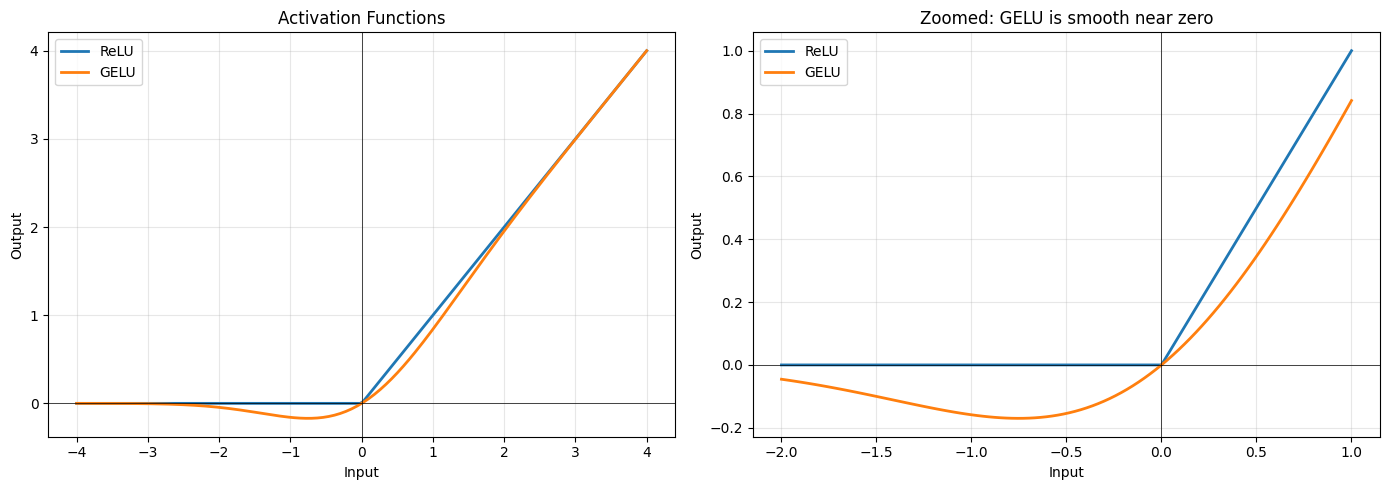

Key differences:
  ReLU: Hard cutoff at 0. Negative inputs → exactly 0
  GELU: Smooth transition. Small negatives → small outputs

GELU allows gradients to flow through small negative values.


In [4]:
# Visualize GELU vs ReLU
x_vals = torch.linspace(-4, 4, 200)

# ReLU
relu_vals = F.relu(x_vals)

# GELU
gelu_vals = F.gelu(x_vals)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Activation functions
ax = axes[0]
ax.plot(x_vals.numpy(), relu_vals.numpy(), label='ReLU', linewidth=2)
ax.plot(x_vals.numpy(), gelu_vals.numpy(), label='GELU', linewidth=2)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('Input')
ax.set_ylabel('Output')
ax.set_title('Activation Functions')
ax.legend()
ax.grid(True, alpha=0.3)

# Zoom on the interesting region
ax = axes[1]
x_zoom = torch.linspace(-2, 1, 100)
ax.plot(x_zoom.numpy(), F.relu(x_zoom).numpy(), label='ReLU', linewidth=2)
ax.plot(x_zoom.numpy(), F.gelu(x_zoom).numpy(), label='GELU', linewidth=2)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('Input')
ax.set_ylabel('Output')
ax.set_title('Zoomed: GELU is smooth near zero')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key differences:")
print("  ReLU: Hard cutoff at 0. Negative inputs → exactly 0")
print("  GELU: Smooth transition. Small negatives → small outputs")
print("\nGELU allows gradients to flow through small negative values.")

## Parameter Count

The FFN is parameter-heavy. Let's count:

$$\text{Params} = d_{model} \times d_{ff} + d_{ff} + d_{ff} \times d_{model} + d_{model}$$
$$= 2 \times d_{model} \times d_{ff} + d_{ff} + d_{model}$$

With $d_{ff} = 4 \times d_{model}$:
$$\approx 2 \times d_{model} \times 4 \times d_{model} = 8 \times d_{model}^2$$

Compare to attention:
$$\text{Attention params} = 4 \times d_{model}^2$$

**The FFN has ~2× the parameters of attention!**

In [5]:
# Count parameters
d_model = 256
d_ff = 1024

ffn = FeedForward(d_model, d_ff)
total_params = sum(p.numel() for p in ffn.parameters())

print("Feed-Forward Network Parameters:")
print(f"  linear1 (expand):  {d_model} × {d_ff} + {d_ff} = {d_model * d_ff + d_ff:,}")
print(f"  linear2 (project): {d_ff} × {d_model} + {d_model} = {d_ff * d_model + d_model:,}")
print(f"  " + "-" * 40)
print(f"  Total: {total_params:,} parameters")
print()

# Compare to attention
attention_params = 4 * d_model * d_model
print(f"For comparison:")
print(f"  Multi-head attention: {attention_params:,} parameters")
print(f"  FFN is {total_params / attention_params:.1f}× larger than attention")

Feed-Forward Network Parameters:
  linear1 (expand):  256 × 1024 + 1024 = 263,168
  linear2 (project): 1024 × 256 + 256 = 262,400
  ----------------------------------------
  Total: 525,568 parameters

For comparison:
  Multi-head attention: 262,144 parameters
  FFN is 2.0× larger than attention


## Position-Wise: What Does That Mean?

"Position-wise" means the FFN operates on each position independently, with no mixing between positions. The same linear layers are applied to every token.

This is in contrast to attention, which mixes information across positions.

```
Attention:  Position 0 ←──────→ Position 1 ←──────→ Position 2
            (tokens communicate)

FFN:        Position 0          Position 1          Position 2
                ↓                   ↓                   ↓
            [FFN(x₀)]           [FFN(x₁)]           [FFN(x₂)]
            (same FFN)          (same FFN)          (same FFN)
```

This independence is intentional. The FFN's job is to process the contextualized representation at each position, transforming "what I gathered from attention" into a more useful form.

In [6]:
# Demonstrate position-wise independence
ffn = FeedForward(d_model=64, d_ff=256, dropout=0.0)

# Process single position
x_single = torch.randn(1, 1, 64)  # batch=1, seq_len=1
out_single = ffn(x_single)

# Process same input as part of longer sequence
x_batch = torch.randn(1, 5, 64)  # batch=1, seq_len=5
x_batch[0, 2, :] = x_single[0, 0, :]  # Put same input at position 2
out_batch = ffn(x_batch)

# Check: position 2 output should match single output
match = torch.allclose(out_single[0, 0], out_batch[0, 2], atol=1e-6)
print(f"Output at position 2 matches single input output: {match}")
print()
print("This proves the FFN processes each position independently.")
print("Other positions don't affect the computation.")

Output at position 2 matches single input output: True

This proves the FFN processes each position independently.
Other positions don't affect the computation.


## What Does the FFN Learn?

Research suggests the FFN acts as a kind of "key-value memory":

- The **first layer** acts as "keys": neurons activate for specific input patterns
- The **second layer** acts as "values": when a neuron activates, it contributes a learned vector to the output

For example, a neuron in $W_1$ might activate when the input is about "capital cities." The corresponding row in $W_2$ adds information relevant to that topic.

This is why FFN layers store so much "knowledge." They're learned lookup tables with billions of entries.

## Variant: SwiGLU

Modern models like LLaMA use **SwiGLU** instead of standard FFN. It's a gated variant:

$$\text{SwiGLU}(x) = (W_1 x \cdot \sigma(W_3 x)) W_2$$

where $\sigma$ is the SiLU (Swish) activation and the $\cdot$ is element-wise multiplication.

The gate ($\sigma(W_3 x)$) controls how much of each expanded dimension flows through. This adds an extra projection but often improves quality for the same parameter count.

In [7]:
class SwiGLU(nn.Module):
    """
    SwiGLU feed-forward network (used in LLaMA, PaLM).
    
    Uses a gating mechanism for improved expressiveness.
    """
    
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        # Note: d_ff is usually smaller here because we have 3 projections
        # Common choice: d_ff = (4 * d_model * 2/3) to match parameter count
        self.w1 = nn.Linear(d_model, d_ff, bias=False)
        self.w2 = nn.Linear(d_ff, d_model, bias=False)
        self.w3 = nn.Linear(d_model, d_ff, bias=False)  # Gate projection
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # SiLU = x * sigmoid(x)
        return self.dropout(self.w2(F.silu(self.w1(x)) * self.w3(x)))

# Compare parameter counts
d_model = 256
d_ff_standard = 1024  # 4×
d_ff_swiglu = 682     # Roughly (4 × d_model × 2/3) to match params

ffn_standard = FeedForward(d_model, d_ff_standard)
ffn_swiglu = SwiGLU(d_model, d_ff_swiglu)

print("Parameter comparison:")
print(f"  Standard FFN (d_ff={d_ff_standard}): {sum(p.numel() for p in ffn_standard.parameters()):,}")
print(f"  SwiGLU (d_ff={d_ff_swiglu}): {sum(p.numel() for p in ffn_swiglu.parameters()):,}")

Parameter comparison:
  Standard FFN (d_ff=1024): 525,568
  SwiGLU (d_ff=682): 523,776


## Division of Labor: Attention vs FFN

The transformer has a clean separation:

| Component | Role | Mechanism |
|-----------|------|------------|
| **Attention** | Communication | Tokens gather information from each other |
| **FFN** | Computation | Each position processes its gathered information |

```
Token representations
        ↓
   [Attention]  ← "Look at other tokens, gather context"
        ↓
   [FFN]        ← "Process this context, extract features"
        ↓
Richer representations
```

This alternation (communicate, compute, communicate, compute) allows the model to build up increasingly abstract representations layer by layer.

## Key Takeaways

1. **FFN is a simple two-layer MLP** applied independently to each position

2. **4× expansion** gives the model a larger workspace for computation

3. **GELU activation** is smooth, helping gradient flow

4. **~2/3 of transformer parameters** are in the FFN (not attention!)

5. **Position-wise** means no cross-position communication (that's attention's job)

## Next: Transformer Block

We now have all the pieces:
- Multi-head attention (communication)
- Feed-forward network (computation)

In the next notebook, we'll combine them with **layer normalization** and **residual connections** to create the complete transformer block. These additions aren't just nice-to-haves. They're essential for training deep networks without gradients vanishing or exploding.